In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from functions import remaptoz_xr
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
from maps_matplot_lib import zon_2Dz, defVarmme, custom_div_cmap
from lib_remapping import remaptoz
import glob, os
from modelsDef import defModels
import pickle

In [7]:
import string
letters = string.ascii_lowercase

In [8]:
indir = '/data/ericglod/Density_binning/Prod_density_april15/mme_histNat/'

varname = defVarmme('salinity'); v = 'S'

var = varname['var_zonal_w/bowl']
legVar = varname['legVar']
unit = varname['unit']

# Density domain
rhomin = 21
rhomid = 26
rhomax = 28
domrho = [rhomin, rhomid, rhomax]

models = defModels()

Working on CanESM2
Working on CCSM4
Working on CESM1-CAM5
Working on CSIRO-Mk3-6-0
Working on FGOALS-g2
Working on GISS-E2-R


/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Working on HadGEM2-ES
Working on IPSL-CM5A-LR
Working on IPSL-CM5A-MR
Working on MIROC-ESM-CHEM
Working on MIROC-ESM


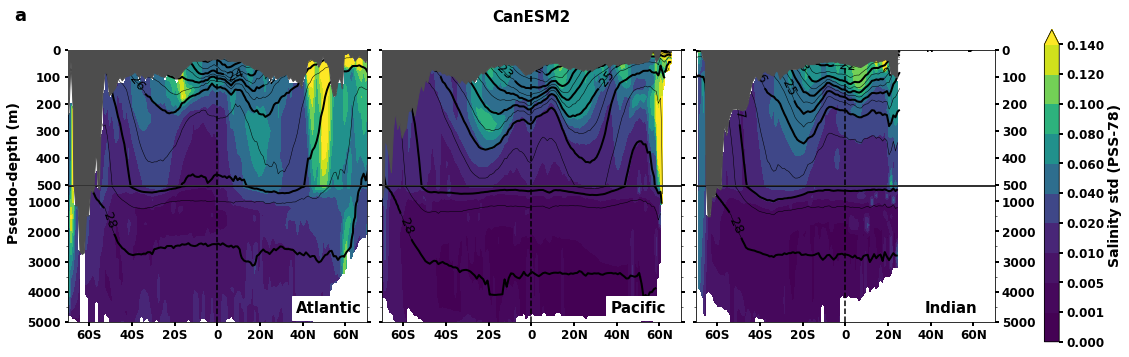

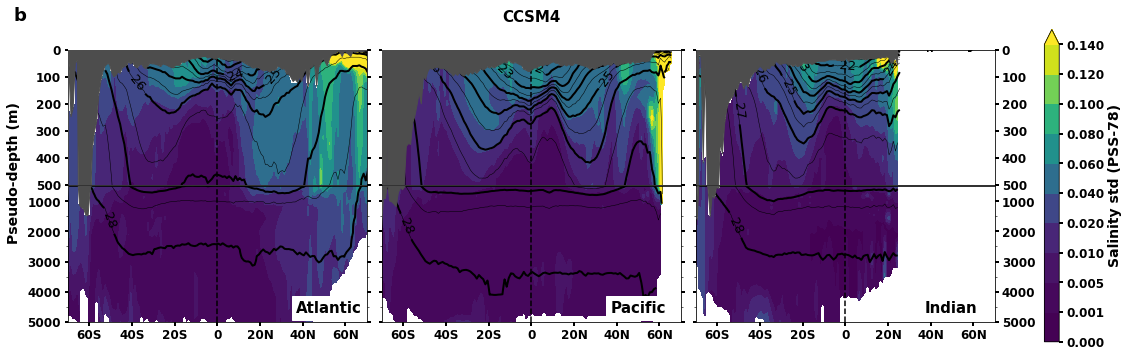

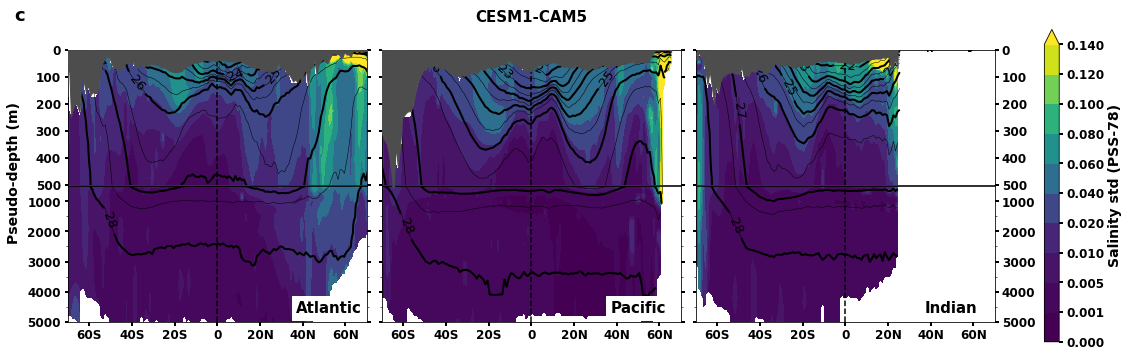

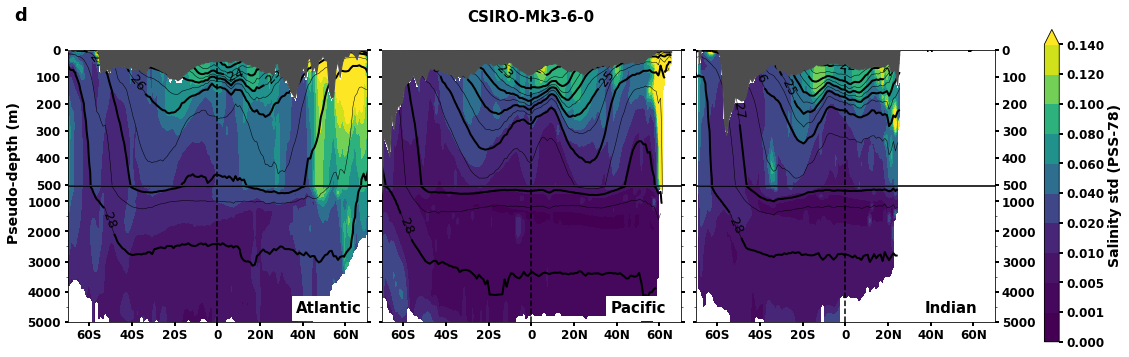

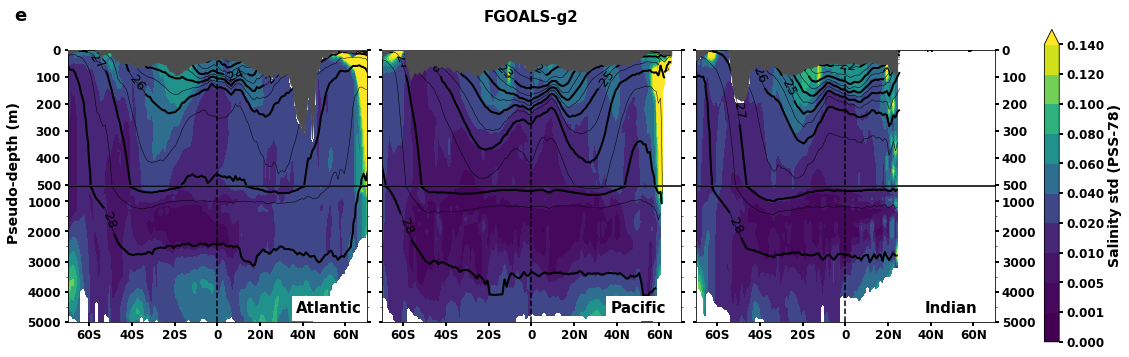

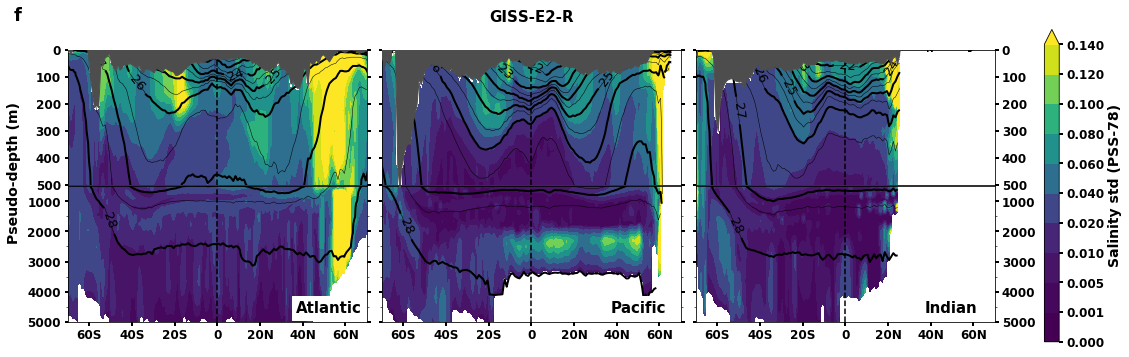

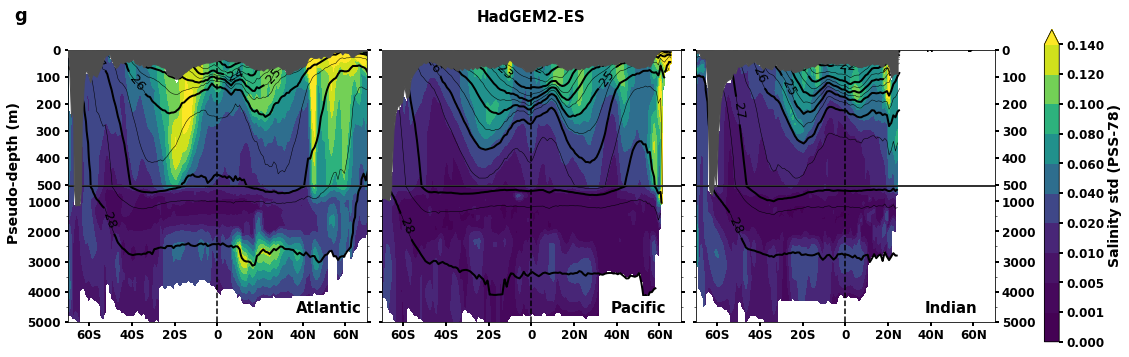

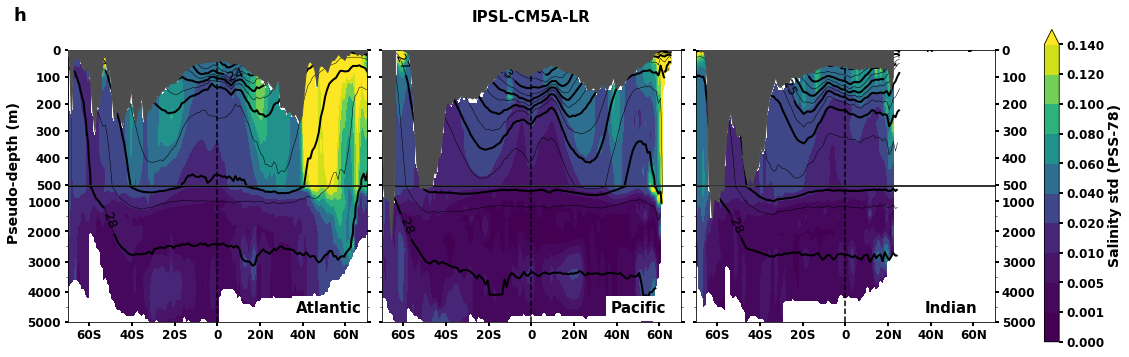

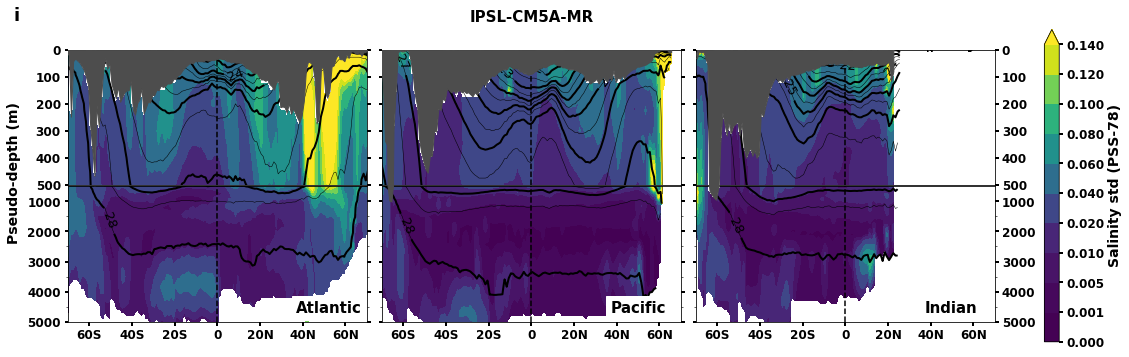

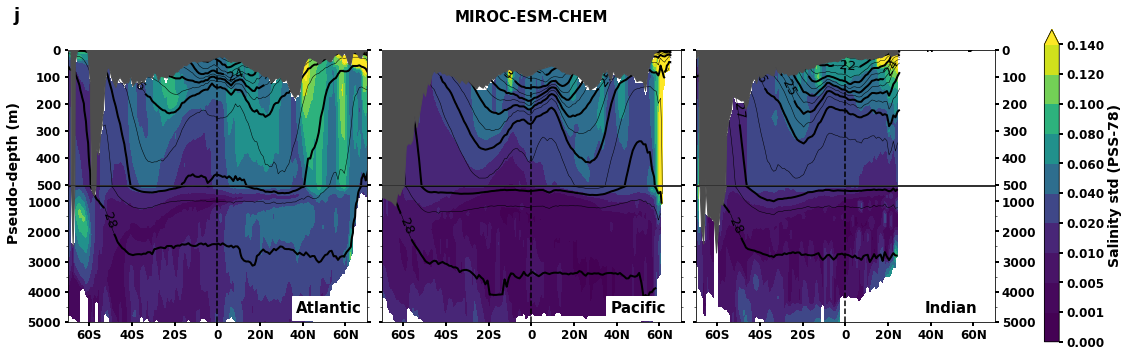

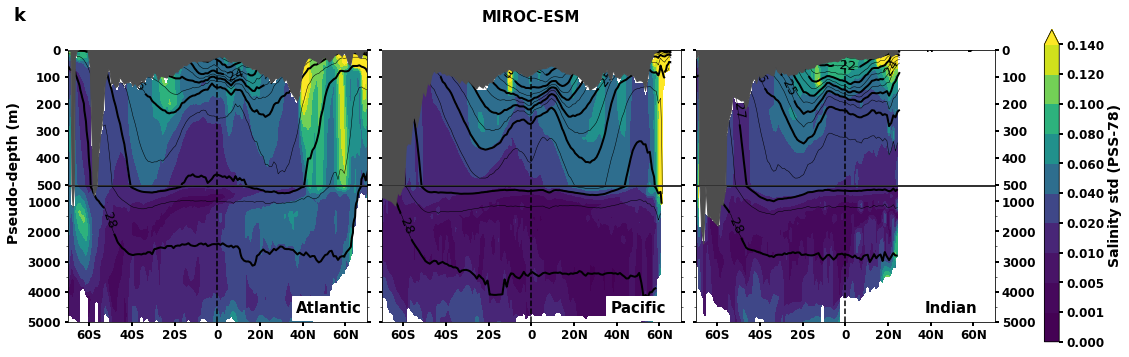

In [18]:
# == Loop on models and plot ==

imodel = 0
for i, model in enumerate(models):
# i=2; model=models[i]

    if len(model['hist-rcp85'])!=0:
        print('Working on', model['name'])
        # -- Read histNat files and variables
        file = glob.glob(indir + 'cmip5.' + model['name'] + '.' + '*zon2D.nc')[0]
        file1d = glob.glob(indir + 'cmip5.' + model['name'] + '.' + '*zon1D.nc')[0]

        f = xr.open_dataset(file,decode_times=False)
        f1d = xr.open_dataset(file1d,decode_times=False)
        stdvar = f.isonsoStd
        lev = f.lev
        lat = f.latitude
        bowl = f1d.ptopsigma.mean(dim='time')

        stdvar = stdvar.where(bowl<stdvar.lev) # Mask above bowl

        # == Remap to z ==
        # Read reference pseudo-depth used for remapping 
        indir_z = '/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/'
        file_z = 'EN4.pseudo_depth.zonal.pkl'
        pseudo_depth = pickle.load( open( indir_z+file_z, "rb" ))

        # Repeat density into (basin,density,latitude) to remap isopycnal surfaces
        lat2d,density2d = np.meshgrid(lat,lev)
        density3d = np.repeat(density2d[np.newaxis,:,:],4,axis=0)

        # Target grid for remapping - WOA13 grid
        targetz = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
           85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
           400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
           1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
           1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
           2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
           3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
           4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]

        # Remap 
        density_z, zbowl = remaptoz(density3d,pseudo_depth,targetz)
        stdvar_z, zbowl = remaptoz_xr(stdvar,pseudo_depth,targetz)

        # == Plot ==

        # -- Make variable bundles for each basin
        varAtl = {'name': 'Atlantic', 'var_change': stdvar_z[1,:,:], 'bowl1': None, 'bowl2': None,
                  'labBowl': None, 'density':density_z[1,:,:]}
        varPac = {'name': 'Pacific', 'var_change': stdvar_z[2,:,:], 'bowl1': None, 'bowl2': None,
                  'labBowl': None, 'density':density_z[2,:,:]}
        varInd = {'name': 'Indian', 'var_change': stdvar_z[3,:,:], 'bowl1': None, 'bowl2': None,
                  'labBowl': None, 'density':density_z[3,:,:]}

        domzed = [0,500,5000]

        # -- Create figure and axes instances
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

        # -- color map
        cmap = 'viridis'

        # -- levels
        levels = [0,0.001,0.005,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.14] #np.arange(0,0.1301,0.01)

        ext_cmap = 'max'
        show_isopyc = True
        contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':show_isopyc}

        # -- Contourf of signal
        cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtl,
                         contourDict, domzed)
        cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPac,
                         contourDict, domzed)
        cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varInd,
                         contourDict, domzed)

        for i in range(3):
            # -- Draw bowl
            axes[0,i].fill_between(lat,y1=0,y2=zbowl[i+1],color='0.3',zorder=10)
            axes[1,i].fill_between(lat,y1=0,y2=zbowl[i+1],color='0.3',zorder=10)

        plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)

        for ax in axes.ravel().tolist():
            ax.tick_params(axis='both', which='major', labelsize=12)

        # -- Add colorbar
        cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels, fraction=0.015, shrink=2.0, pad=0.05)
        cb.set_label('%s std (%s)' % (legVar, unit), fontweight='bold',fontsize=14)
        cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
        cb.ax.yaxis.set_tick_params(which='major',width=2,labelsize=12)

        plt.figtext(.006,.96,letters[imodel],fontweight='bold',fontsize=18)
        plt.figtext(.0005,.35,'Pseudo-depth (m)',rotation='vertical',fontweight='bold',fontsize=14)

        plotTitle = model['name']
        axes[0,1].set_title(plotTitle, y=1.25, fontweight='bold', fontsize=15, verticalalignment='top')

        plt.savefig('noise_'+model['name']+'.png', bbox_inches='tight',dpi=150) 

        imodel = imodel+1